In [1]:
%matplotlib inline

# Lets revise the Metropolis–Hastings algorithm!

In [2]:
import numpy as np
import collections
import itertools
import matplotlib.pyplot as plt
import scipy.integrate
import functools

#### (define some helper functions)

In [152]:
def method_vectorize(func):
    """ A dectorator which makes a method operate on arrays """
    vecd = np.vectorize(func)
    def f(self, *args, **kwargs):
        return vecd(self, *args, **kwargs)
    return f

def one_or_more(func):
    """ A dectorator which makes a function callable with size=N """
    def f(*args, **kwargs):
        if 'size' in kwargs:
            size = kwargs['size']
            del kwargs['size']
        else:
            size = 1
        
        if size < 1: return None
        if size == 1: return func(*args, **kwargs)
        if size > 1: return np.array([func(*args, **kwargs) for x in range(size)])
    return f

### The Objective...
We want to generate values from a particular distribution $P$, but direct sampling of $P$ is difficult and its parameters are unknown. However, we can calculate the probability of a given value, $P(\theta)$.

However, we *do* know how to sample from a distribution $T(\theta)$. Essentially, every time we sample $x_i$ from $T$, we want to use $P(x_i)$ to move the parameters of $T$ closer to the parameters of $P$.

#### Define a gaussian random variable class

Setting *can_sample*=True simulates the 'unknown' distribution. We can calculate $P(x)$ but we cannot take samples from it

In [198]:
class Gaussian():
    def __init__(self, mean, sigma, can_sample = True):
        self.mean = float(mean)
        self.sigma = float(sigma)
        self.denom = 2 * self.sigma**2
        self.can_sample = can_sample

    @one_or_more
    def sample(self, force=False):
        assert force or self.can_sample, \
            "Cannot sample from this distribution"
        return np.random.normal(loc=self.mean, scale=self.sigma)
        
    @method_vectorize
    def pdf(self, x):
        y = np.exp(-((x - self.mean)**2) / self.denom ) 
        return y / np.sqrt(np.pi * self.denom)
    __call__ = pdf


### Define our unknown distribution
Our unkown distribution is actually $P\sim N(\mu=40, \sigma=2)$, but we cannot sample from it

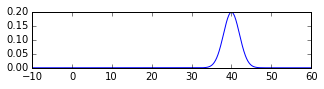

In [210]:
P = Gaussian(40, 2, can_sample = False)

plt.figure(figsize=(5, 1))
ar = np.arange(-10, 60, 0.1)
plt.plot(ar, P(ar))
plt.show()

### Iteratively estimate paremeters of P

We start off with a 'proposal' distribution, $T \sim N(\theta, 1)$, where $\theta = 0$ is the initial mean.

Every iteration, do the following:
 - Generate a sample $x_i$ from $T(\theta_t)$. 
 - Propose a new distribution $T'$ with new parameters $\theta'$. In this case, $\theta' = x_i$
 - Accept $\theta^{t+1} = \theta'$ with probability $a = r(\theta'|\theta_t)$, otherwise keep $\theta_t$
 - This will have the effect of 'moving' $\theta_t$ towards the real parameter $\mu$ most of the time.
 
$r$ is the acceptance ratio, defined as:

$$\begin{align}
r(\theta', \theta_t) &= r_1 r_2, \\ \mathrm{where} \\
r_1 &= \frac{P(\theta_t)}{P(\theta')} \\
r_2 &= \frac{T_t(\theta_t|\theta')}{T_t(\theta'|\theta_t)}
\end{align}$$

The first component $r_1$ is the liklihood of the new parameter divided by the current one, calculated from $P(x)$, which we can compute. Note that $r_1 \geq 1$ when $\theta'$ is more likely than $\theta_t$

The second component is the ratio of the proposal density in each direction, which is always 1 if $T$ is symmetric.

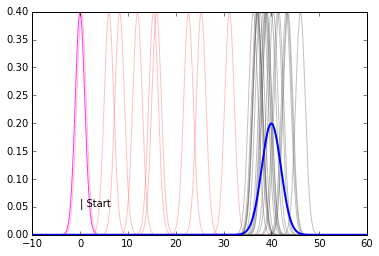

In [223]:
sigma = 1

T = Gaussian(0, sigma)
theta = T.mean
samples = []

# Plot initial T
ar = np.arange(-10, 60, 0.1)
plt.plot(ar, T(ar), color=(1, 0, 1, 0.8))

for i in range(10000):
    # Sample T
    x = T.sample()
    samples.append(x)
    
    # Generate a proposal distribution
    theta_proposed = x
    T_proposed = Gaussian(theta_proposed, sigma)
    
    # Calculate the acceptance probability
    r1 = P(theta_proposed) / P(theta)
    r2 = T_proposed(theta)/T(theta_proposed)
    r = r1 * r2
    
    # Accept T' with probability r
    if np.random.uniform() < r:
        T = T_proposed
        theta = theta_proposed

    # Plot the path
    if (i < 100 and i%10 == 0):
        plt.plot(ar, T(ar), color=(1, 0.4, 0.4, 0.4))
    elif i%500 == 0:
        plt.plot(ar, T(ar), color=(0.4, 0.4, 0.4, 0.4))
        
plt.plot(ar, P(ar), linewidth = 2)
plt.text(0, 0.05, '| Start')
plt.show()


Note that it takes about 110 iterations to converge (show in red). 

Once the proposal distribution arrives near the real distribution, it will hop around a lot of its shape doesn't match $P$ very well, and sequential samples may have unwanted corellation. However, the histogram of samples generated still matches the desired histogram.

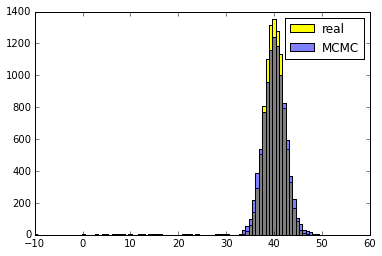

In [224]:
hist = functools.partial(plt.hist, bins=100, range=(ar[0], ar[-1]))
hist(P.sample(force=True, size=len(samples)), color=(1, 1, 0, 1))
hist(samples, color=(0, 0, 1, 0.5))
plt.legend(['real', 'MCMC'], loc='best')
plt.show()

Although the *distribution* of samples is similar to the random variable, the sampled values are actually a random walk.

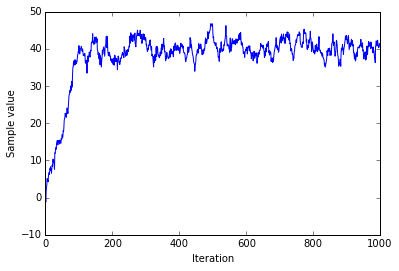

In [229]:
plt.plot(samples[1:1000])
plt.xlabel('Iteration')
plt.ylabel('Sample value')
plt.show()